# Patients analysis

## Dataprocessing
### Imports

In [1]:
import pandas as pdb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from dbspro.notebook import *
from datetime import date
import scanpy as sc

sns.set_theme(style="whitegrid", font_scale=1.3)

sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300, facecolor='white')
sc.settings.figdir = "../figures"

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.19.2 scipy==1.5.2 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0


In [2]:
%matplotlib inline

In [3]:
# Functions

def today():
    return date.today().strftime("%y%m%d")

print(today())

def clr_normalize_adata(adata, on_cells=False, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""
    def seurat_clr(x):
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)
   
    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    if on_cells:
        adata.X = np.apply_along_axis(seurat_clr, 1, adata.X)
    else:
        x = np.array(adata.X)
        adata.X = np.log1p(np.divide(x, gmean(x[x>0], axis=0)))
    return adata


220516


### Data loading

In [4]:
# Load metadata
abc_target = pd.read_csv("../data/patients.abc_target.csv", names=["abc", "target"]).set_index("abc").to_dict()["target"]
display(abc_target)
targets = list(abc_target.values())
targets.remove("Her2_CD63")
display(targets)
sample_names= pd.read_csv("../data/patients.samples.tsv", dtype=str, sep="\t")
samples = sorted(sample_names["Sample"].to_list())
display(samples)
display(sample_names)

{'ABC01': 'EGFR',
 'ABC12': 'Her2_CD63',
 'ABC09': 'CD9',
 'ABC03': 'CD3',
 'ABC18': 'PD-1',
 'ABC07': 'CD4',
 'ABC22': 'CD8',
 'ABC19': 'PD-L1',
 'ABC13': 'IGF-1R',
 'ABC14': 'NY-ESO1',
 'ABC16': 'EpCam'}

['EGFR',
 'CD9',
 'CD3',
 'PD-1',
 'CD4',
 'CD8',
 'PD-L1',
 'IGF-1R',
 'NY-ESO1',
 'EpCam']

['ID_PE002', 'ID_PE009', 'ID_PE011']

,Sample,Reads,FastqPath
0,ID_PE002,2015296,/Users/pontus.hojer/analysis/DBS-Pro_Exosomes/...
1,ID_PE009,2731408,/Users/pontus.hojer/analysis/DBS-Pro_Exosomes/...
2,ID_PE011,731517,/Users/pontus.hojer/analysis/DBS-Pro_Exosomes/...


In [5]:
# Load data
data_raw = pd.read_csv("../data/patients.tsv.gz", sep="\t")

# Rename ABCs to targets
data_raw.replace({"Target": abc_target}, inplace=True)

# Filter out UMIs with only one read count
print("Size before:", len(data_raw))
data_raw = data_raw[data_raw["ReadCount"] > 1]
print("Size after:", len(data_raw))

Size before: 1078963
Size after: 412756


### Overall QC

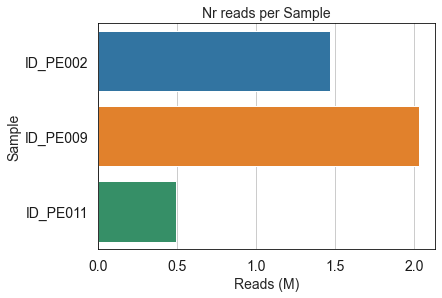

In [6]:
d = data_raw.groupby("Sample", as_index=False).sum()
d["ReadCount"] /= 1_000_000
ax = sns.barplot(data=d, y="Sample", x="ReadCount", order=samples)
_ = ax.set_xlabel("Reads (M)")
_ = ax.set_title("Nr reads per Sample")

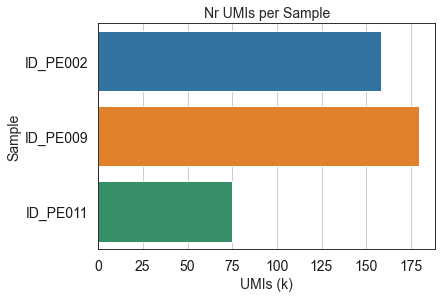

In [7]:
d = data_raw.groupby("Sample", as_index=False).count()
d["UMI"] /= 1_000
ax = sns.barplot(data=d, y="Sample", x="UMI", order=samples)
_ = ax.set_xlabel("UMIs (k)")
_ = ax.set_title("Nr UMIs per Sample")

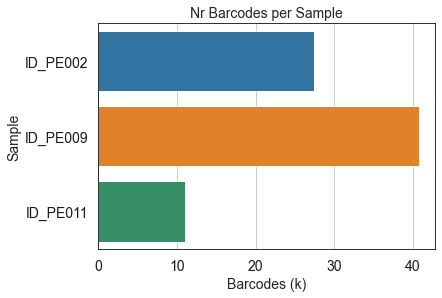

In [8]:
d = data_raw.groupby("Sample").agg({"Barcode":"nunique"})
d["Barcode"] /= 1_000
ax = sns.barplot(data=d, y=d.index, x="Barcode", order=samples)
_ = ax.set_xlabel("Barcodes (k)")
_ = ax.set_title("Nr Barcodes per Sample")

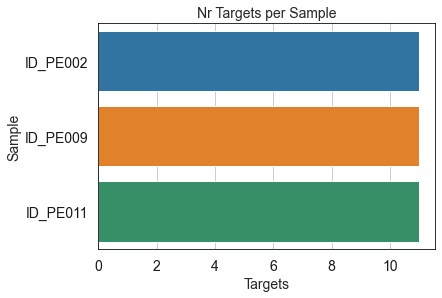

In [9]:
d = data_raw.groupby("Sample").agg({"Target":"nunique"})
ax = sns.barplot(data=d, y=d.index, x="Target", order=samples)
_ = ax.set_xlabel("Targets")
_ = ax.set_title("Nr Targets per Sample")

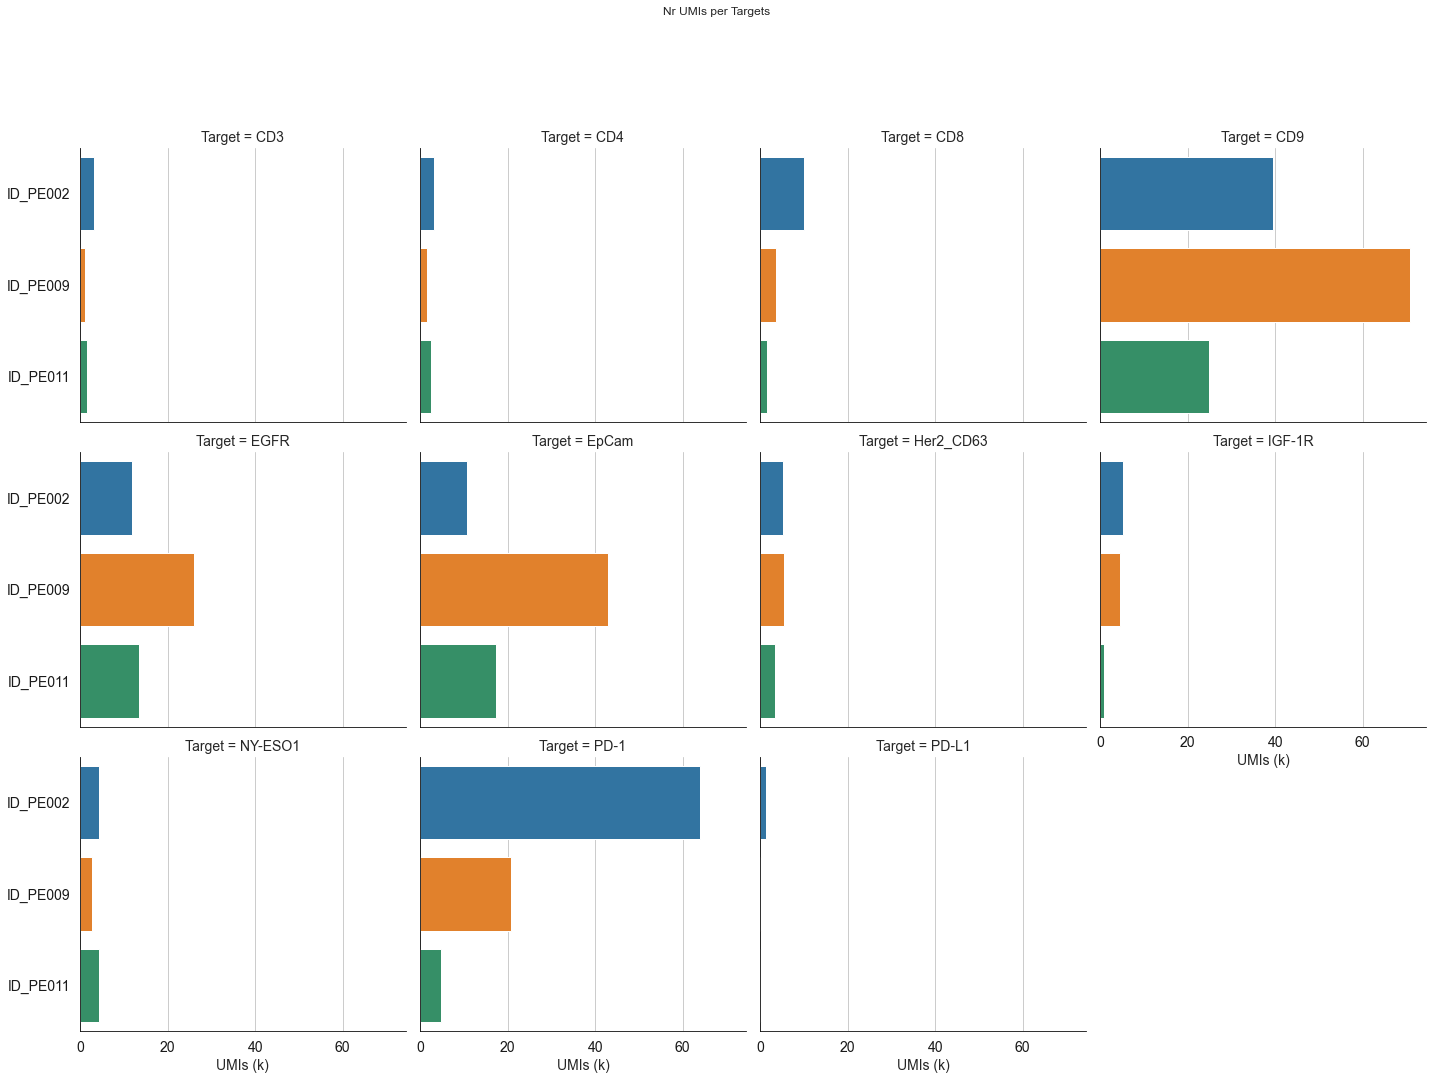

In [10]:
d = data_raw.groupby(["Sample", "Target"], as_index=False).agg({"UMI":"count"})
d["UMI"] /= 1000
g = sns.catplot(data=d, y="Sample", x="UMI",  col="Target", col_wrap=4, kind="bar")
g.fig.subplots_adjust(top=0.85)
_ = g.fig.suptitle("Nr UMIs per Targets")
_ = g.set_axis_labels("UMIs (k)", "")

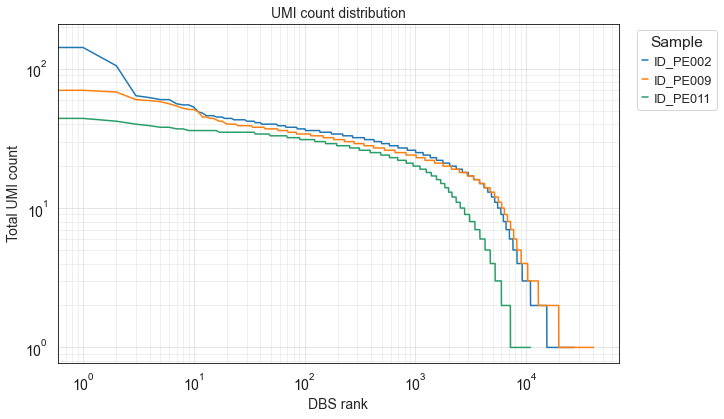

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("UMI count distribution")
for sample in samples:
    temp = data_raw[data_raw["Sample"] == sample].groupby("Barcode", as_index=False)["UMI"].count().sort_values(by="UMI",ascending=False).reset_index(drop=True)
    try:
        temp.plot(ax=ax, y="UMI", logx=True, logy=True, label=sample)
    except TypeError:
        pass
    
ax.set_xlabel("DBS rank")
ax.set_ylabel("Total UMI count")
ax.grid('on', which='major', axis='y', alpha=0.5 )
ax.grid('on', which='major', axis='x',alpha=0.5)
ax.grid('on', which='minor', axis='y', alpha=0.3)
ax.grid('on', which='minor', axis='x', alpha=0.3)
_ = plt.legend(bbox_to_anchor=(1.02, 1), title="Sample", loc='upper left')

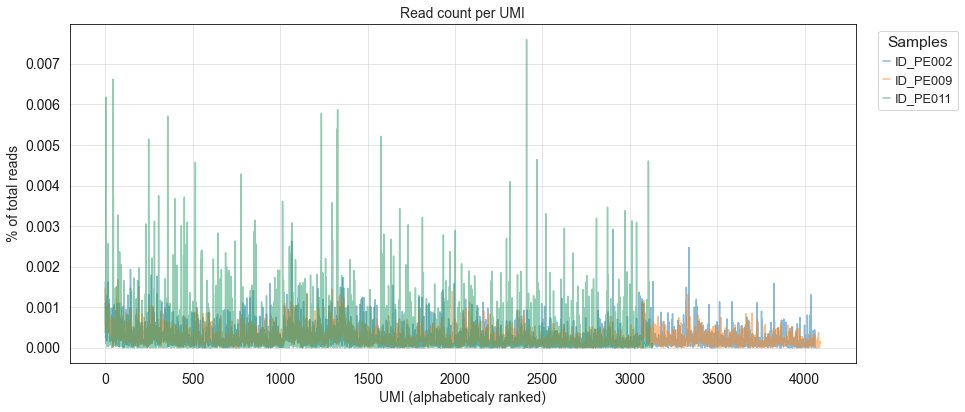

In [12]:
fig, ax = plt.subplots(figsize=(14,6))
ax.set_title("Read count per UMI")
for sample in samples:
    temp = data_raw[data_raw["Sample"] == sample].groupby("UMI", as_index=False)["ReadCount"].sum().sort_values(by="UMI",ascending=False).reset_index(drop=True)
    temp["GC"] = temp["UMI"].apply(lambda x: sum([c in {"G","C"} for c in x])/len(x)) 
    temp["ReadCount"] = temp["ReadCount"]/temp["ReadCount"].sum()
    try:
        temp.plot(ax=ax, y="ReadCount", logx=False, logy=False, label=sample, alpha=0.5)
    except TypeError:
        pass
ax.set_xlabel("UMI (alphabeticaly ranked)")
ax.set_ylabel("% of total reads")
ax.grid('on', which='major', axis='y', alpha=0.5 )
ax.grid('on', which='major', axis='x',alpha=0.5)
ax.grid('on', which='minor', axis='y', alpha=0.3)
ax.grid('on', which='minor', axis='x', alpha=0.3)
_ = plt.legend(bbox_to_anchor=(1.02, 1), title="Samples", loc='upper left')

(-5.0, 200.0)

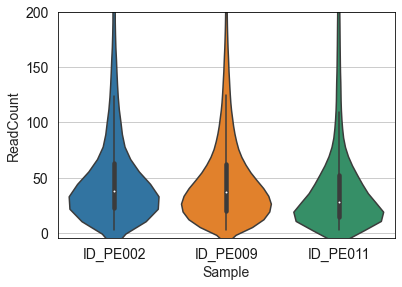

In [13]:
ax = sns.violinplot(data=data_raw.groupby(["Sample","Barcode"], as_index=False)["ReadCount"].sum(), kind="violin", x="Sample", y="ReadCount", bw_adjust=0.1, scale="width")
ax.set_ylim(-5,200)

## Filter and create count matrix

In [15]:
data_count = []
for sample in tqdm(samples):
    print(sample)
    d = data_raw[data_raw["Sample"]==sample]\
            .filter_rc(1)\
            .filter_uc(1)\
            .filter_ratio(2)\
            .filter_target_count(1)\
            .filter_dups(0.5, min_len=2)
    
    # Remove Her2_CD63 after filtering since they shared barcode
    d = d[d['Target']!='Her2_CD63']
    data_count.append(d.to_matrix(qc=True).assign(Sample=sample))
    print("")
data_count = pd.concat(data_count)

  0%|          | 0/3 [00:00<?, ?it/s]

ID_PE002
Filtering molecules per readcount gt 1
Barcodes = 27,455 (-0, -0.0%, runtime:0.018523693084716797 s)
Filtering barcodes by total UMI count gt 1
Barcodes = 15,408 (-12,047, -43.88%, runtime:0.03719305992126465 s)
Filtering barcodes by Reads/UMI ratio gt 2
Barcodes = 14,772 (-636, -4.13%, runtime:0.039086103439331055 s)
Filtering for targets with UMI count gt 1
Barcodes = 14,142 (-630, -4.26%, runtime:0.040157318115234375 s)
Filter barcodes whose UMI + Target combos have a jaccard index >0.5
Barcodes = 9,731 (-4,411, -31.19%, runtime:7.037670135498047 s)

ID_PE009
Filtering molecules per readcount gt 1
Barcodes = 40,793 (-0, -0.0%, runtime:0.019507884979248047 s)
Filtering barcodes by total UMI count gt 1
Barcodes = 19,729 (-21,064, -51.64%, runtime:0.042569875717163086 s)
Filtering barcodes by Reads/UMI ratio gt 2
Barcodes = 18,433 (-1,296, -6.57%, runtime:0.0455019474029541 s)
Filtering for targets with UMI count gt 1
Barcodes = 16,757 (-1,676, -9.09%, runtime:0.04321885108947

In [16]:
data_count.groupby("Sample").count()["total_count"]

Sample
ID_PE002     9598
ID_PE009    12410
ID_PE011     4818
Name: total_count, dtype: int64

In [17]:
# Save counts to simply rerunning analysis from here.
data_count.to_csv("../data/patients.counts.tsv.gz", sep="\t")

# Comment out the row above and run the code below if rerunning analysis
#data_count = pd.read_csv("../data/patients.counts.tsv.gz", sep="\t").set_index("Barcode")

## Per Droplet QC

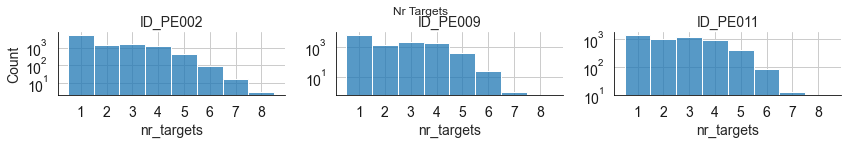

In [18]:
bins = np.array(range(1,data_count["nr_targets"].max()+1))

g = sns.displot(data_count, x="nr_targets", col="Sample", bins=bins, 
                height=2, aspect=2, facet_kws={'sharey': False})
g.fig.subplots_adjust(top=0.8)
_ = g.fig.suptitle("Nr Targets")
g.set(yscale="log", xticks = bins[:-1] + 0.5, xticklabels=bins[:-1])
g.set_titles("{col_name}")

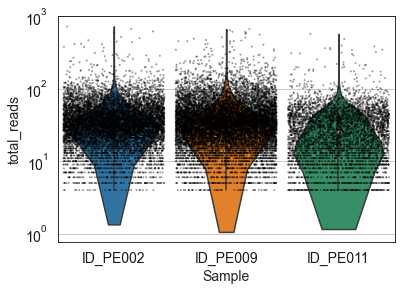

In [19]:
ax = sns.violinplot(data=data_count, y="total_reads", x="Sample", scale="width", cut=0.5)
ax = sns.stripplot(data=data_count, y="total_reads", x="Sample", size=2, jitter=0.45, color="black", alpha=0.4)
ax.set_yscale("log")

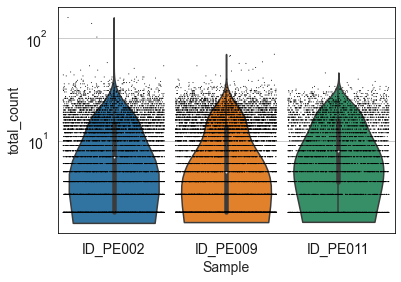

In [20]:
ax = sns.violinplot(data=data_count, y="total_count", x="Sample", bw=0.5, scale="width", cut=0.1)
ax = sns.stripplot(data=data_count, y="total_count", x="Sample", size=1, jitter=0.45, color="black")
ax.set_yscale("log")

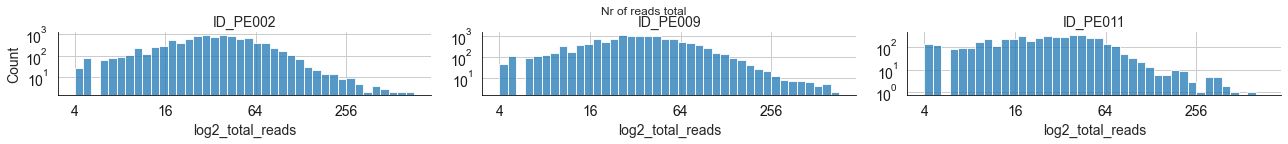

In [21]:
import matplotlib.ticker as tkr
d = data_count.copy()
d["log2_total_reads"] = np.log2(d["total_reads"])
g = sns.displot(d, x="log2_total_reads", col="Sample", col_wrap=3, bins=40,
                height=2, aspect=3, facet_kws={'sharey': False})
g.fig.subplots_adjust(top=0.8)
_ = g.fig.suptitle("Nr of reads total")
g.set(yscale="log", )
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: str(int(2**x))))

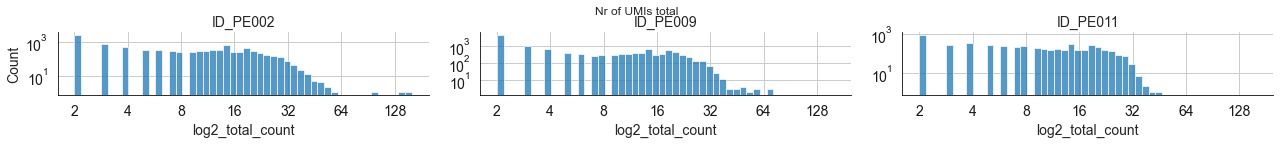

In [22]:
d = data_count.copy()
d["log2_total_count"] = np.log2(d["total_count"])
g = sns.displot(d, x="log2_total_count", col="Sample", col_wrap=3, bins=50,
                height=2, aspect=3, facet_kws={'sharey': False})
g.fig.subplots_adjust(top=0.8)
_ = g.fig.suptitle("Nr of UMIs total")
g.set(yscale="log", )
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: str(int(2**x))))

## Filter data further

In [23]:
data_filt = data_count.groupby("Sample", as_index=False)\
    .apply(lambda x: x[(x["total_count"]>1) & (x["total_count"] < 25)])

In [24]:
data_filt.groupby("Sample").count()["total_count"]

Sample
ID_PE002     9064
ID_PE009    11920
ID_PE011     4565
Name: total_count, dtype: int64

### Code for supplemental figure 4

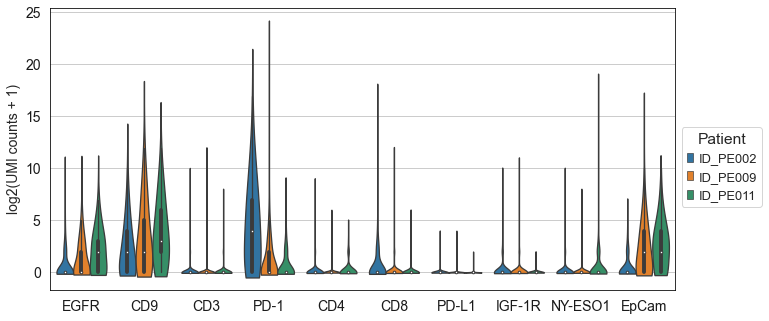

In [25]:
d=data_filt.melt(id_vars="Sample", value_vars=targets).copy()
#d["value"] = np.log2(d["value"] + 1)
fig, ax = plt.subplots(figsize=(14,5))
ax = sns.violinplot(ax=ax, data=d, x="Target", y="value", hue="Sample", 
                    scale="width", bw=0.6, cut=0.2, linewidth=1.3, inner="box") 
_ = ax.set_ylabel("log2(UMI counts + 1)")
_ = ax.set_xlabel("")
fig.subplots_adjust(right=0.8)
_ = plt.legend(bbox_to_anchor=(1, 0.6), title="Patient", loc='upper left')

for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}.Patients.violinplots.{ext}", dpi=300)

### Code for figure 4A

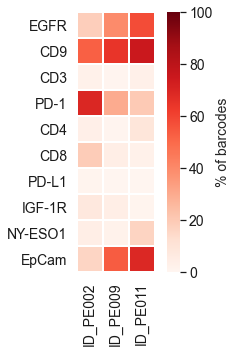

In [26]:
d = data_filt.copy()
d.loc[:,targets] = d.loc[:,targets].clip(upper=1)
d = d.loc[:, list(targets) + ["Sample"]]
fig, ax = plt.subplots(figsize=(4,5))
sns.heatmap(data=d.groupby("Sample").apply(lambda x: 100 * x.sum() / x.count()).T, ax=ax,
           square=True, vmin=0, vmax=100, annot=False, fmt='.0f',
           linewidths=.5, cmap="Reds", cbar_kws={"label":"% of barcodes"})
_ = plt.ylabel("")
_ = plt.xlabel("")
plt.tight_layout()

for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}.Patients.heatmap_targets.{ext}", dpi=300)

### Code for figure 4B

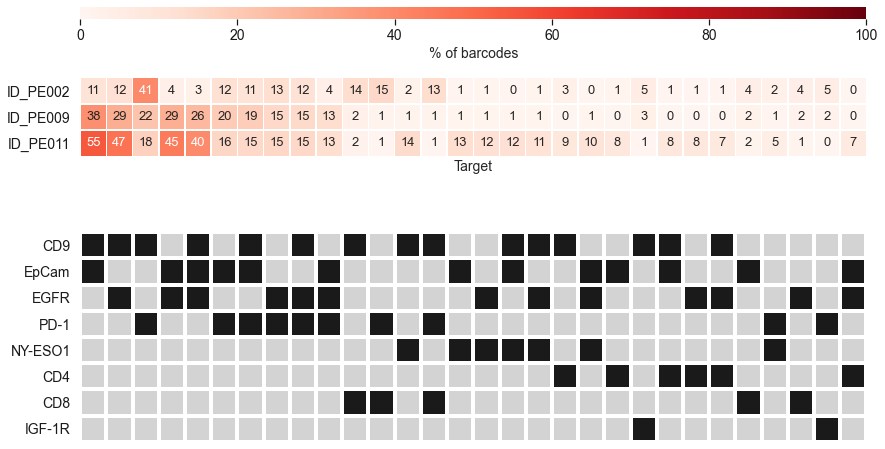

In [27]:
d = data_filt.copy()
combos=[]
for i in range(2,4):
    for ts in combinations(targets, i):
        combo = " & ".join(sorted(ts))
        combos.append(combo)
        ts_list = list(ts)
        t = ts_list.pop()
        temp = (d[t] > 0)
        while ts_list:
            t = ts_list.pop()
            temp = np.logical_and(temp, (d[t] > 0))
        
        d[combo] = temp.astype(int) 

d = d.loc[:,combos+ ["Sample"]]
d = d.groupby("Sample").apply(lambda x: 100 * x.sum() / x.count())
maxd = d.mean()#agg(lambda x: x.std()/x.mean()).copy()
maxd.name = "max"
d = d.append(maxd)
d = d.sort_values(by="max", axis=1, ascending=False)
d = d.iloc[:3,:30]


columns = [set(item.split(" & ")) for item in list(d.columns.values)]
upset = []
for t in targets:
    upset.append([t in c for c in columns])

upset = pd.DataFrame(data=np.array(upset), index=targets, columns=d.columns.values)
upset = upset[upset.sum(1)> 0]
upset = upset.reindex(upset.sum(1).sort_values(ascending=False).index)

grid_kws = {"height_ratios": (.02, .32, .4), "hspace": .0}
f, (cbar_ax, ax1, ax2) = plt.subplots(nrows=3, gridspec_kw=grid_kws, figsize=(14,8))
ax1 = sns.heatmap(data=d, ax=ax1, cbar_ax=cbar_ax, 
                 cbar_kws={"orientation": "horizontal", "shrink": 10 ,"label":"% of barcodes"},
                 square=True, vmin=0, vmax=100, annot=True, fmt='.0f',
                 linewidths=.5, cmap="Reds", xticklabels=False,
                 annot_kws={"fontsize":13})

_ = ax1.set_ylabel("")

ax2 = sns.heatmap(data=upset, cbar=False, xticklabels=False, linewidths=3,
                  square=True, cmap=["lightgrey", "k"])

for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}.Patients.heatmap_top30_combos.{ext}", dpi=300)

## Scanpy analysis

In [28]:
d = data_filt.copy()
X = d.loc[:,targets].values
obs = d.loc[:, ["total_count", "total_reads", "nr_targets", "Sample"]].reset_index()
var = pd.DataFrame(index=targets)
adata = sc.AnnData(X, obs, var)

/Users/pontus.hojer/miniconda3/envs/dbspro/lib/python3.6/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [29]:
adata

AnnData object with n_obs × n_vars = 25549 × 10
    obs: 'level_0', 'Barcode', 'total_count', 'total_reads', 'nr_targets', 'Sample'

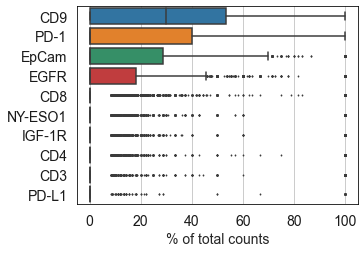

In [30]:
sc.pl.highest_expr_genes(adata, n_top=10, )

... storing 'Sample' as categorical


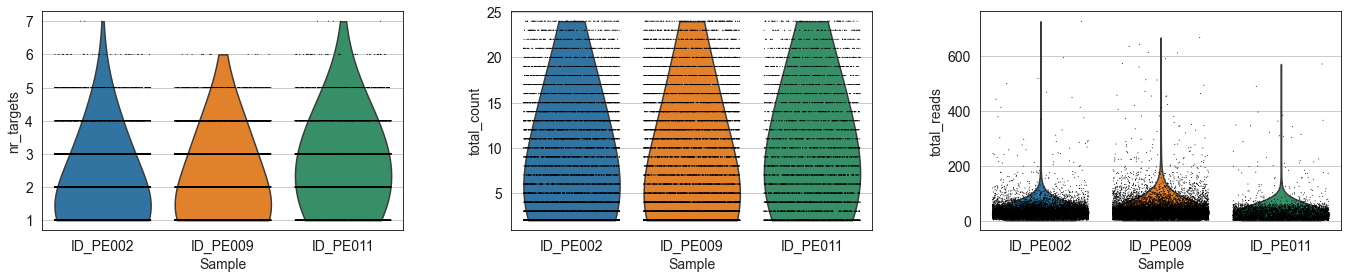

In [31]:
sc.pl.violin(adata, ['nr_targets', 'total_count', "total_reads"],
             jitter=0.4, multi_panel=True, bw=1, groupby="Sample")

In [32]:
target_counts = adata.var.copy()
target_counts["count"] = (adata.X != 0).sum(axis=0)

target_counts

,count
EGFR,9047
CD9,15973
CD3,436
PD-1,10792
CD4,841
CD8,2400
PD-L1,91
IGF-1R,1270
NY-ESO1,1423
EpCam,11028


In [33]:
sc.pp.filter_cells(adata, min_genes=3)

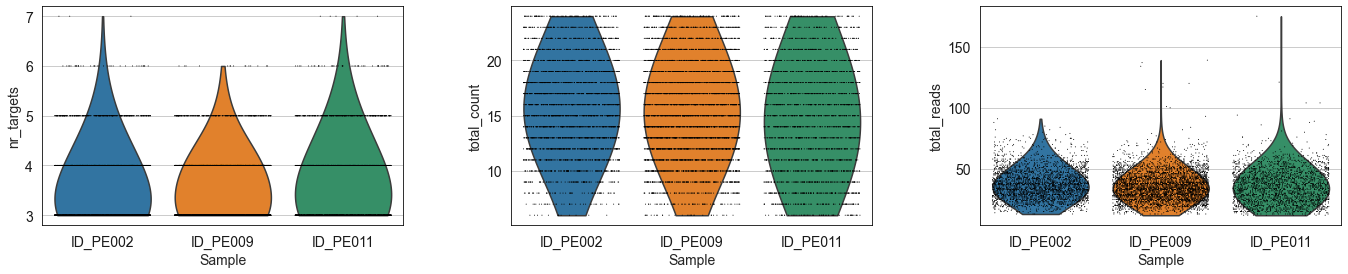

In [34]:
sc.pl.violin(
    adata, 
    ['nr_targets', 'total_count', "total_reads"],
    jitter=0.4, multi_panel=True, bw=1, groupby="Sample"
)

In [35]:
print(adata.obs['Sample'].value_counts())

ID_PE009    4137
ID_PE002    2806
ID_PE011    2291
Name: Sample, dtype: int64


In [36]:
adata

AnnData object with n_obs × n_vars = 9234 × 10
    obs: 'level_0', 'Barcode', 'total_count', 'total_reads', 'nr_targets', 'Sample', 'n_genes'
    uns: 'Sample_colors'

In [37]:
adata.raw = adata
for s in samples:
    clr_normalize_adata(adata[adata.obs.Sample == s, :], on_cells=False, inplace=True)

In [38]:
sc.tl.pca(adata, svd_solver='arpack')

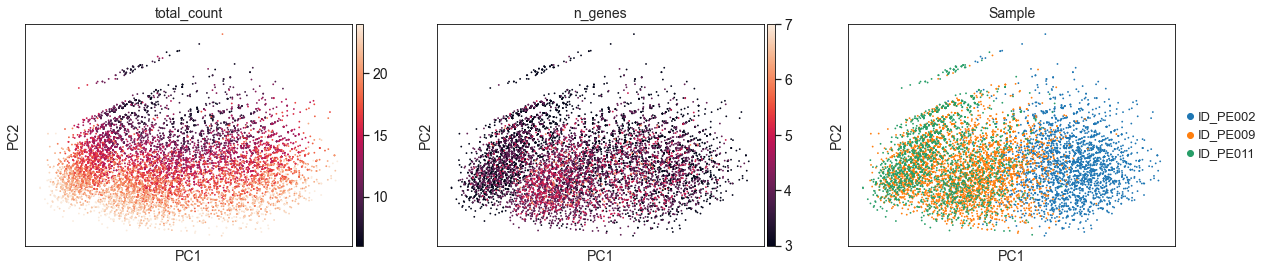

In [39]:
sc.pl.pca(adata, color=['total_count', 'n_genes', 'Sample'])

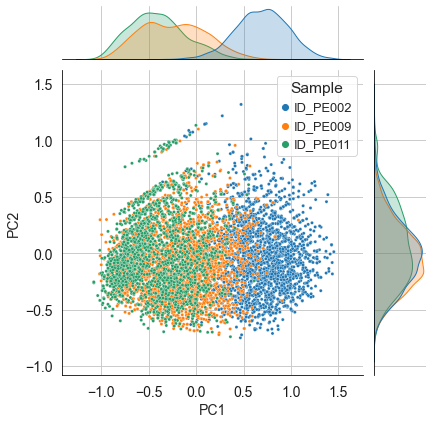

In [40]:
plotdf = sc.get.obs_df(adata, keys=["Sample"], obsm_keys=[("X_pca",0),("X_pca",1)])
plotdf.columns = ['Sample', 'PC1', 'PC2']
g = sns.jointplot(data=plotdf, x="PC1", y="PC2", hue="Sample", 
                  kind="scatter", s=10, marginal_kws={"common_norm": False})

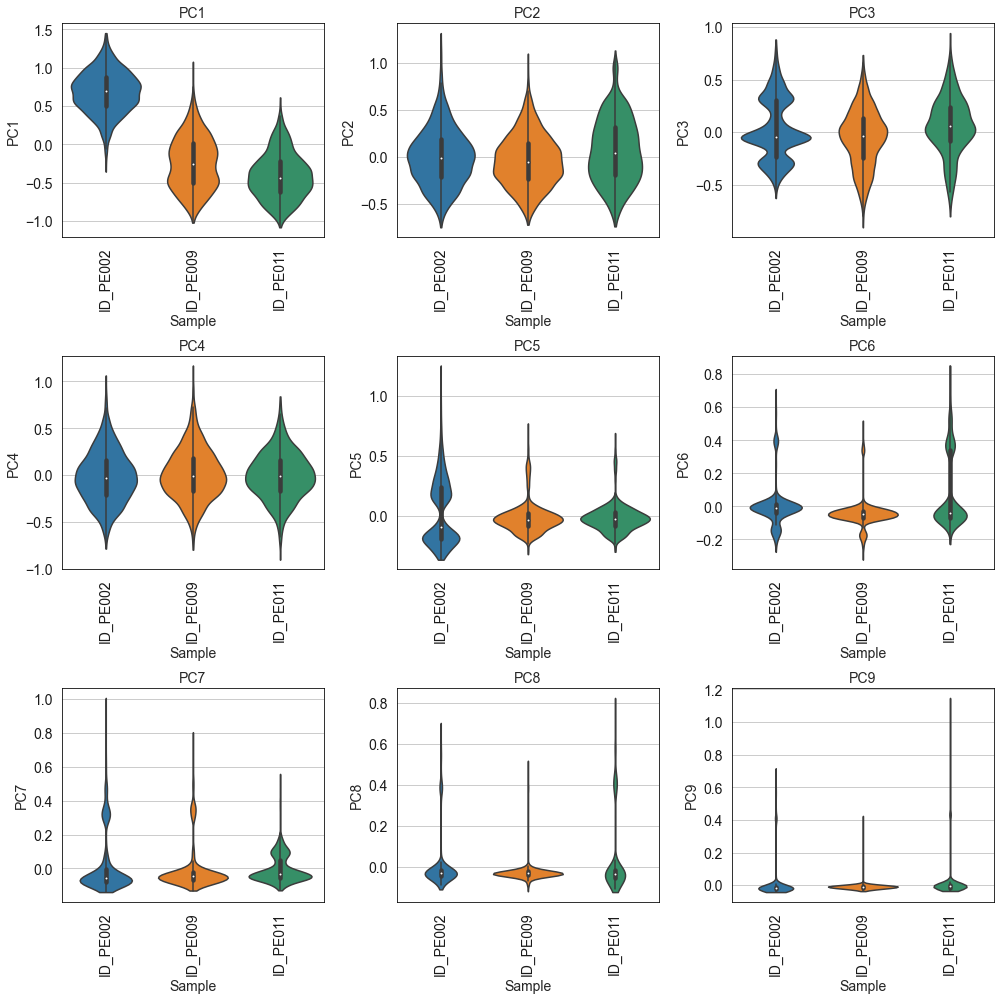

In [41]:
pcs = [f"PC{i}" for i in range(1, adata.obsm["X_pca"].shape[1]+1)]
df = pd.DataFrame(data = adata.obsm["X_pca"], columns=pcs)
df["Sample"] = adata.obs["Sample"].values

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,14))
for pc, ax in zip(pcs, axes.ravel()):
    ax = sns.violinplot(data=df, x="Sample", y=pc, ax=ax, cut=0, bw_adjust=0.1)
    ax.set_title(pc)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

In [42]:
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=None)

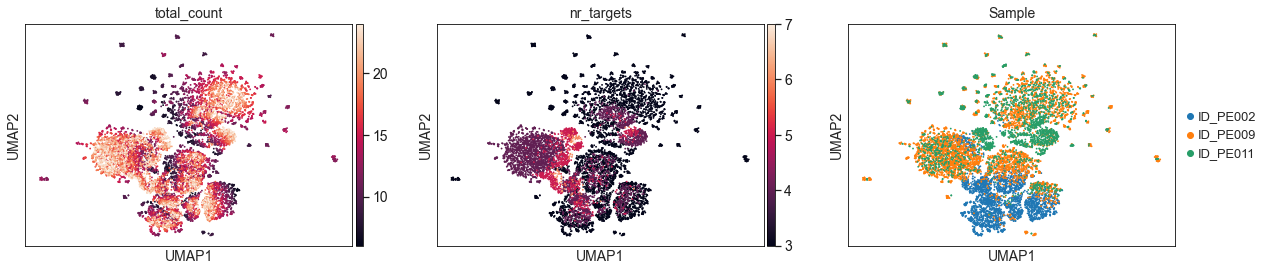

In [43]:
sc.tl.umap(adata, min_dist=0.9)
sc.pl.umap(adata, color=['total_count', 'nr_targets', 'Sample'])

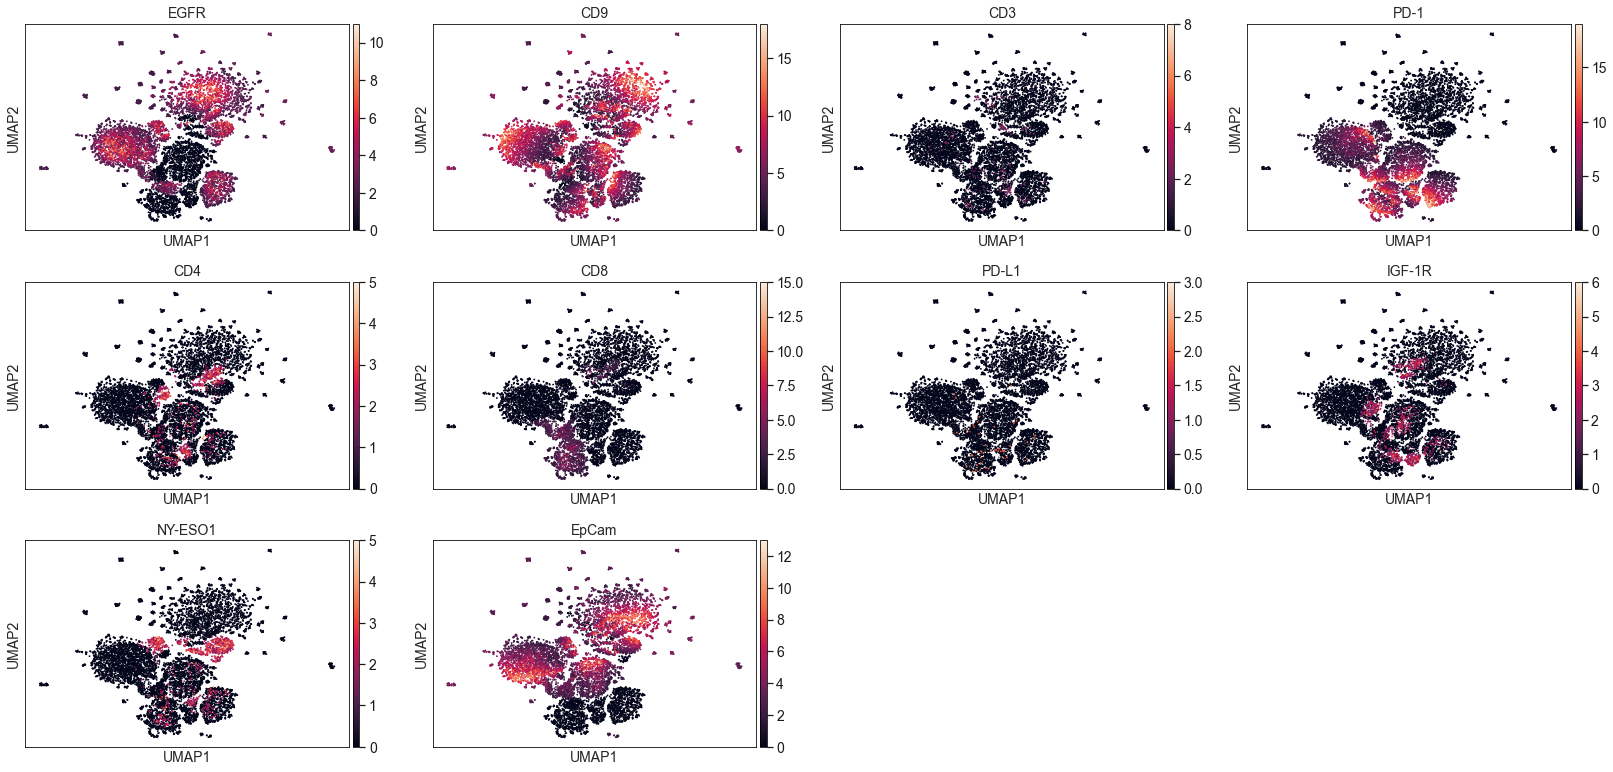

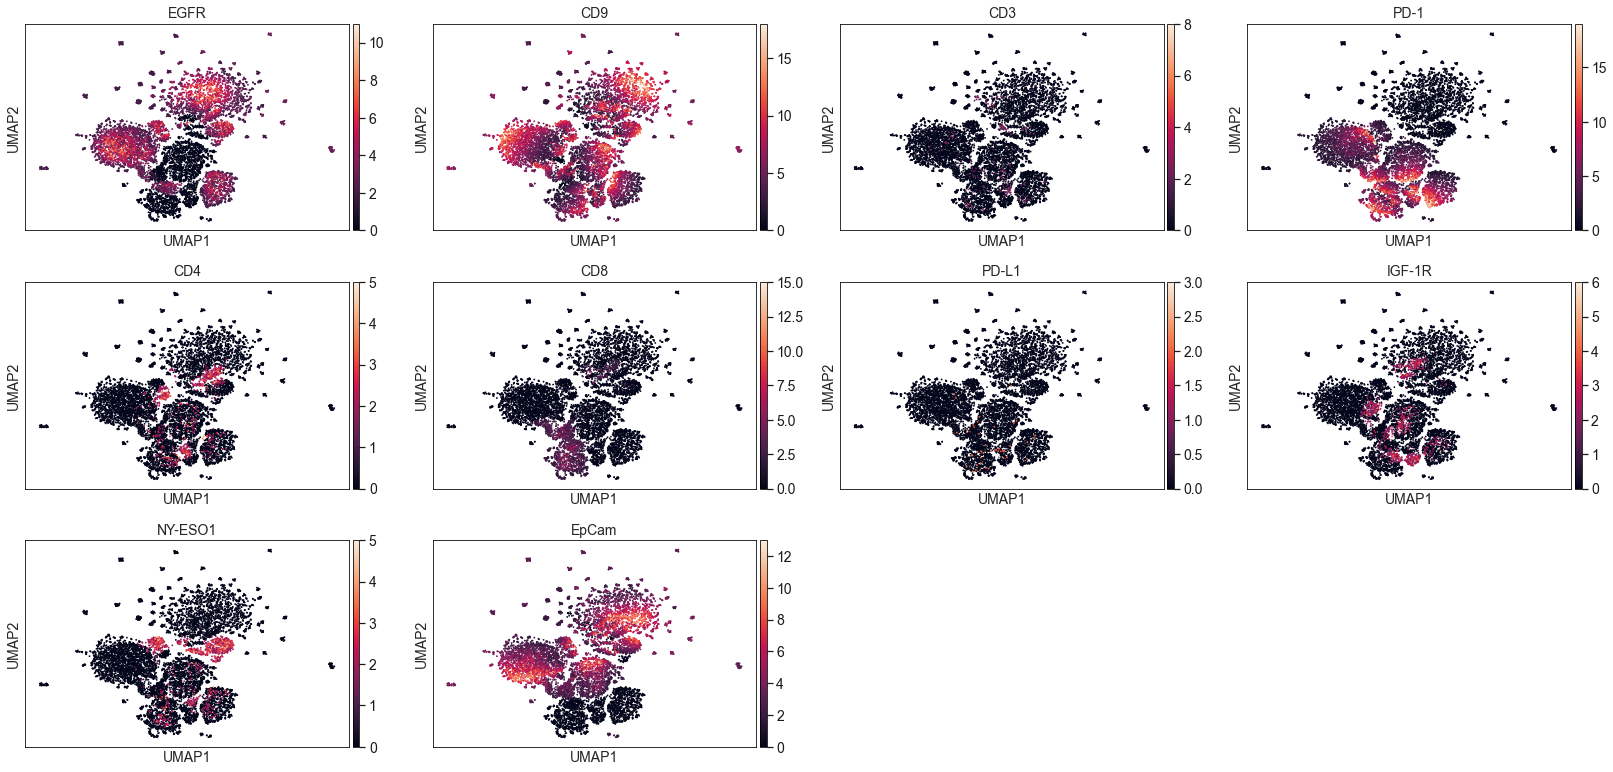

In [44]:
for ext in ["png", "svg"]:
    sc.pl.umap(
        adata, color=adata.var.index.to_list(), ncols=4, 
        save=f"{today()}_Patients_UMAP_targets.{ext}"
    )

### Code for figure 4C

In [45]:
sc.tl.louvain(adata, resolution=0.6)

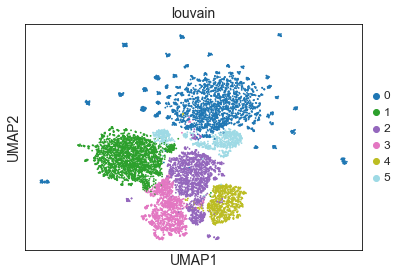

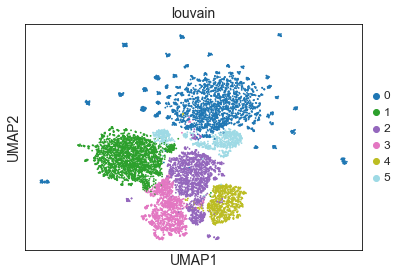

In [46]:
for ext in ["png", "svg"]:
    sc.pl.umap(
        adata,
        color='louvain', 
        palette="tab20", 
        save=f"{today()}_Patients_UMAP_louvain.{ext}",
        legend_fontsize=12, 
        legend_fontoutline=2,
    )

### Code for figure 4D

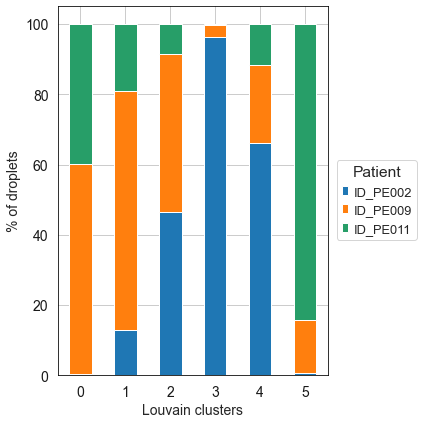

In [47]:
tmp = pd.crosstab(adata.obs['louvain'],adata.obs['Sample'], normalize='index')
tmp *= 100
fig, ax = plt.subplots(figsize=(6,6))
ax = tmp.plot.bar(stacked=True, ax=ax)
_ = plt.legend(bbox_to_anchor=(1.01, 0.6), title="Patient", loc='upper left')
_ = ax.set_ylabel("% of droplets")
_ = ax.set_xlabel("Louvain clusters")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
for ext in ["png", "svg"]:
    plt.savefig(f"../figures/{today()}_Patients_louvain_proportions.{ext}", dpi=300)

### Code for figure 4F

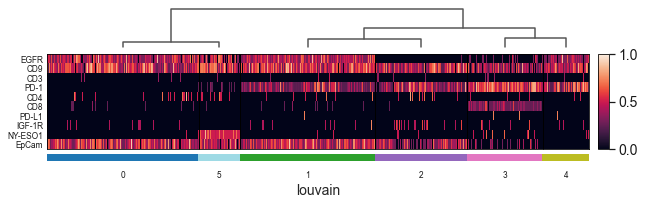

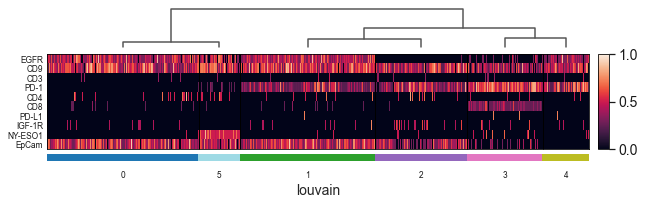

In [48]:
sc.tl.dendrogram(
    adata,
    groupby="louvain"
)
for ext in ["png", "svg"]:
    ax = sc.pl.heatmap(
        adata,
        var_names = adata.var.index.to_list(),
        groupby="louvain", 
        save=f"{today()}_Patients_louvain_target_heatmap.{ext}",
        swap_axes = True, 
        standard_scale="var",
        use_raw=False,
        dendrogram=True,
    )

### Code for figure 4E

In [49]:
sc.tl.embedding_density(adata, groupby='Sample')

/Users/pontus.hojer/miniconda3/envs/dbspro/lib/python3.6/site-packages/scanpy/plotting/_tools/__init__.py:1186: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  color_map.set_over('black')
/Users/pontus.hojer/miniconda3/envs/dbspro/lib/python3.6/site-packages/scanpy/plotting/_tools/__init__.py:1187: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd"))
  color_map.set_under('lightgray')
/Users/pontus.hojer/miniconda3/envs/dbspro/lib/python3.6/site-packages/scanpy/plotting/_tools/scatterplots.py:370: MatplotlibDeprecationW

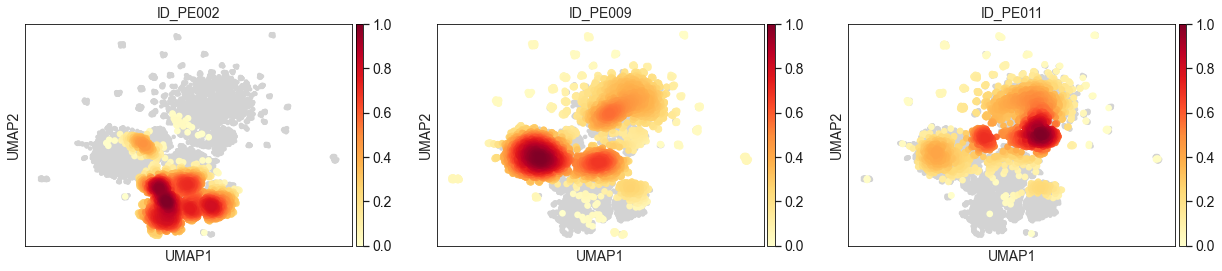

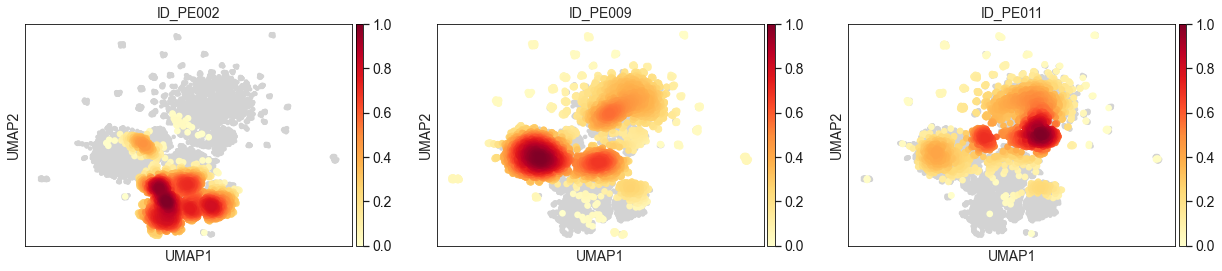

In [50]:
for ext in ["png", "svg"]:
    sc.pl.embedding_density(
        adata, groupby='Sample', vmax=1, vmin=0,
        save=f"{today()}_Patients_UMAP_density.{ext}"
    )